# Flood Duration
Tralala

In [2]:
%run setup.ipynb
data_dir = Path('../data' )
output_dir = Path('../output') 

In [3]:
hourly_data = xr.open_dataset(data_dir / 'SL_hourly_data.nc')
hourly_data.close()

In [4]:
hourly_data

<xarray.Dataset> Size: 40MB
Dimensions:               (time: 359377, record_id: 8)
Coordinates:
  * time                  (time) datetime64[ns] 3MB 1983-01-01 ... 2023-12-31
  * record_id             (record_id) int64 64B 52 60 552 59 57 61 58 50
Data variables: (12/14)
    sea_level             (record_id, time) float32 12MB ...
    lat                   (record_id) float32 32B ...
    lon                   (record_id) float32 32B ...
    station_name          (record_id) <U16 512B ...
    station_country       (record_id) <U30 960B ...
    station_country_code  (record_id) float32 32B ...
    ...                    ...
    ssc_id                (record_id) <U4 128B ...
    last_rq_date          (record_id) datetime64[ns] 64B ...
    MHHW                  (record_id) float64 64B ...
    MSL                   (record_id) float64 64B ...
    sea_level_MHHW        (record_id, time) float64 23MB ...
    year_storm            (time) int64 3MB ...
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (hourly)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2024-08-19T14:27:33Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The UHSLC assembles and distributes the Fast Deli...
    processing_level:       Fast Delivery (FD) data undergo a level 1 quality...
    acknowledgment:         The UHSLC Fast Delivery database is supported by ...

In [132]:
# load the data
SL_daily_max = xr.open_dataset(data_dir / 'SL_daily_max.nc')
SL_daily_max.close()

SL_daily_max

<xarray.Dataset> Size: 2MB
Dimensions:               (record_id: 8, time: 14975)
Coordinates:
  * record_id             (record_id) int64 64B 52 60 552 59 57 61 58 50
  * time                  (time) datetime64[ns] 120kB 1983-01-01 ... 2023-12-31
Data variables: (12/15)
    sea_level             (time, record_id) float32 479kB ...
    lat                   (record_id) float32 32B ...
    lon                   (record_id) float32 32B ...
    station_name          (record_id) <U16 512B ...
    station_country       (record_id) <U30 960B ...
    station_country_code  (record_id) float32 32B ...
    ...                    ...
    last_rq_date          (record_id) datetime64[ns] 64B ...
    MHHW                  (record_id) float64 64B ...
    MSL                   (record_id) float64 64B ...
    sea_level_MHHW        (time, record_id) float64 958kB ...
    year_storm            (time) int64 120kB ...
    flood_day             (time, record_id) bool 120kB ...
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (hourly)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2024-08-19T14:27:33Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The UHSLC assembles and distributes the Fast Deli...
    processing_level:       Fast Delivery (FD) data undergo a level 1 quality...
    acknowledgment:         The UHSLC Fast Delivery database is supported by ...

In [154]:
# Extracting the necessary data
flood_day = SL_daily_max['flood_day']
time = SL_daily_max['time']
station_names = SL_daily_max['station_name'].values

# Convert time to pandas datetime
time = pd.to_datetime(time.values)

# Initialize a dictionary to hold results
flood_events = {}

# Loop through each station
for i, station in enumerate(station_names):
    station_flood_days = flood_day[:, i].values
    station_flood_days = pd.Series(station_flood_days, index=time)
    
    # Group by year
    station_flood_days_by_year = station_flood_days.groupby(station_flood_days.index.year)
    
    # Initialize list to hold all events for this station
    station_events = []
    
    for year, data in station_flood_days_by_year:
        flood_event_durations = []
        current_event_length = 0
        
        for day in data:
            if day:
                current_event_length += 1
            else:
                if current_event_length > 0:
                    flood_event_durations.append(current_event_length)
                current_event_length = 0
        
        # Append the last event if it was ongoing at the end of the year
        if current_event_length > 0:
            flood_event_durations.append(current_event_length)
        
        # Store the events for this year
        station_events.append({
            "year": year,
            "events": flood_event_durations
        })
    
    # Store the results for the station
    flood_events[station] = station_events

# Example of how the corrected data looks for one station
flood_events[list(flood_events.keys())[0]]

[{'year': 1983, 'events': [3, 2, 3, 5, 5, 3, 4, 4, 3, 4, 1]},
 {'year': 1984, 'events': [1, 5, 2, 2, 1, 1, 2, 5, 2, 5, 1, 5, 1, 3]},
 {'year': 1985, 'events': [1, 1, 3, 3, 3, 3]},
 {'year': 1986, 'events': [1, 2, 4, 3, 1, 1, 3]},
 {'year': 1987, 'events': [1, 1, 2, 1, 1, 5, 1]},
 {'year': 1988, 'events': [1, 1, 8, 5, 1, 6, 5, 6, 6, 1, 3, 5, 2, 3]},
 {'year': 1989, 'events': [1, 1, 5, 1, 1, 3, 1, 2, 6, 1]},
 {'year': 1990, 'events': [1, 2, 2, 1, 2, 2, 1, 1]},
 {'year': 1991, 'events': [1, 1, 4, 4, 1]},
 {'year': 1992, 'events': [1, 1, 2, 3, 3, 5, 4, 5, 2, 2, 1, 4]},
 {'year': 1993, 'events': [1, 2, 4, 2, 3, 3, 1, 2, 1]},
 {'year': 1994, 'events': [2, 1, 3, 1, 8, 3, 5, 1]},
 {'year': 1995, 'events': [1, 2, 6, 1, 1, 2, 7, 2, 1, 1, 4, 1, 1, 1]},
 {'year': 1996, 'events': [5, 3, 1, 6, 1, 1, 2, 2, 6, 7, 1, 4, 1, 9]},
 {'year': 1997, 'events': [7, 6, 1, 1, 1, 5]},
 {'year': 1998, 'events': [1, 3, 3, 2, 1, 1, 2, 3, 4, 4, 1, 3, 2]},
 {'year': 1999, 'events': [3, 1, 1, 1, 1, 1, 3, 9, 1, 1]},
 {'

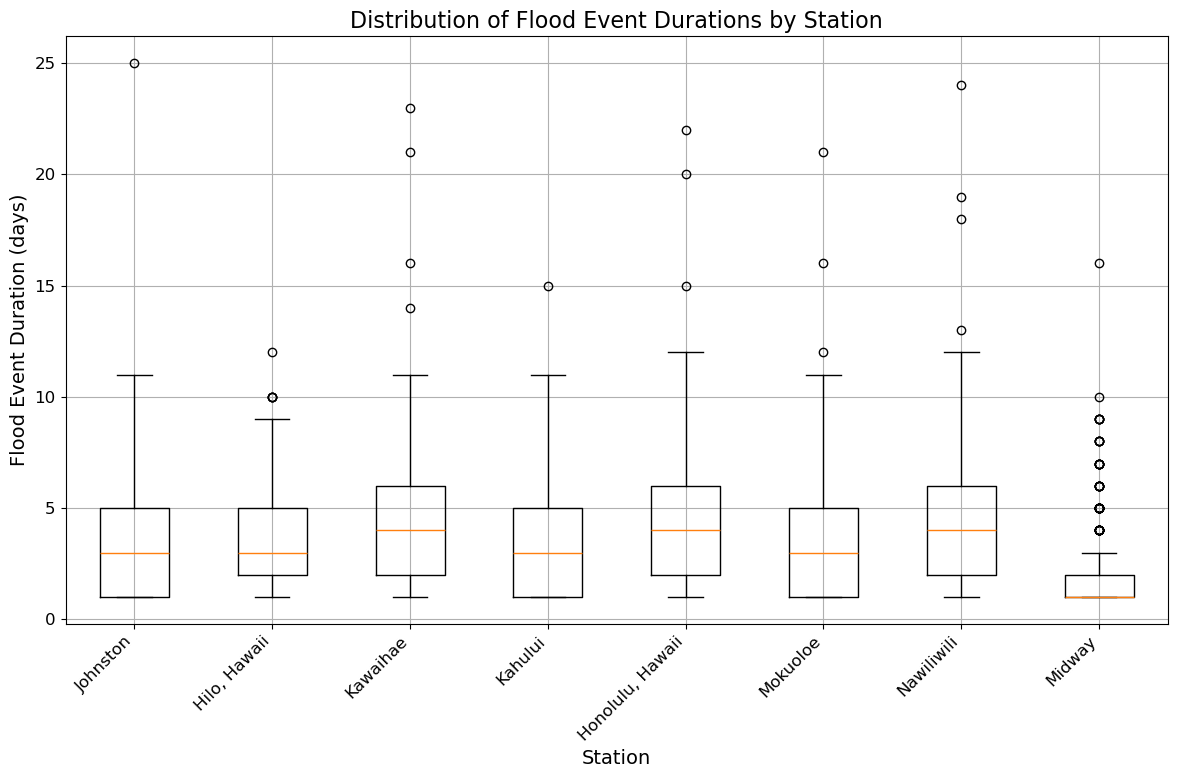

In [156]:
# Prepare data for box plot
station_names = list(flood_events.keys())
all_durations = []

# Collecting all durations for each station
for station in station_names:
    station_durations = []
    for year_data in flood_events[station]:
        station_durations.extend(year_data["events"])
    all_durations.append(station_durations)

# Plotting
plt.figure(figsize=(12, 8))
plt.boxplot(all_durations, labels=station_names, vert=True)
plt.title('Distribution of Flood Event Durations by Station')
plt.xlabel('Station')
plt.ylabel('Flood Event Duration (days)')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()

plt.show()

Text(0.5, 0, 'Year')

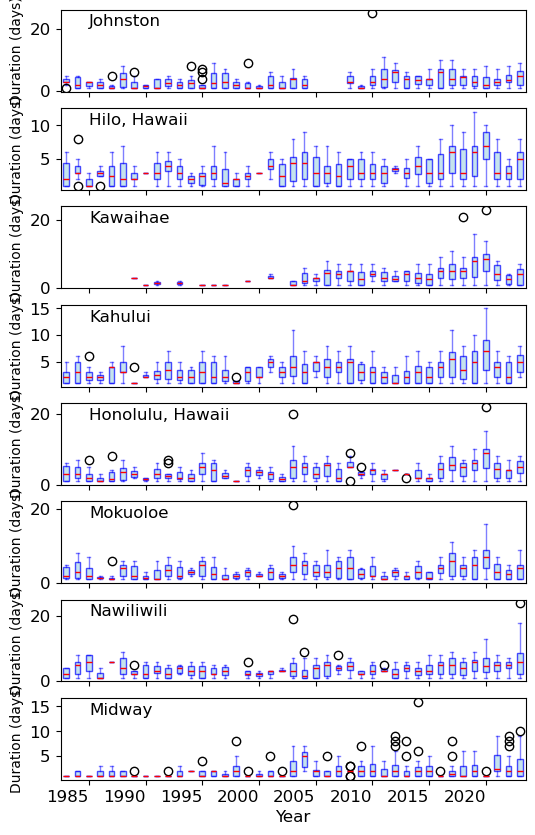

In [167]:
# Setting up the plot grid again with larger station names

# Determine unique years in the dataset
years = sorted(set(year_data["year"] for station_events in flood_events.values() for year_data in station_events))

# Setting up the plot grid
num_stations = len(station_names)
# Determine the 5-year intervals for labeling
five_year_ticks = [year for year in years if year % 5 == 0]

# Setting up the plot grid again with individual subplots and station names inside the plots
fig, axes = plt.subplots(nrows=num_stations, ncols=1, figsize=(6, 10), sharex=True)

# Plotting for each station
for ax, station in zip(axes, station_names):
    yearly_durations = {year: [] for year in years}
    
    # Populate the yearly durations
    for year_data in flood_events[station]:
        year = year_data["year"]
        yearly_durations[year].extend(year_data["events"])
    
    # Prepare data for boxplot
    boxplot_data = [yearly_durations[year] for year in years]
    
    # Create the boxplot
    ax.boxplot(
        boxplot_data, 
        positions=range(len(years)),
        patch_artist=True, 
        boxprops=dict(facecolor='lightblue', color='blue', alpha=0.7),
        medianprops=dict(color='red'),
        whiskerprops=dict(color='blue', alpha=0.5),
        capprops=dict(color='blue', alpha=0.5)
    )
    
    # Add station name inside the plot
    ax.text(2, ax.get_ylim()[1] * 0.8, station, fontsize=12, ha='left', color='black')
    ax.set_ylabel('Duration (days)', fontsize=10)
    ax.grid(False)

# Clean up and remove x-axis labels from all but the last subplot
for ax in axes[:-1]:
    ax.set_xticks([])

# Set x-ticks and labels for every 5 years
axes[-1].set_xticks([years.index(year) for year in five_year_ticks])
axes[-1].set_xticklabels(five_year_ticks, ha='right')
axes[-1].set_xlabel('Year', fontsize=12)



In [ ]:
# Loop through each sensor column
for column in flood_hour_df.columns:
    flood_duration_day[column] = []
    
    # Find the indices where flooding starts and ends
    flood_events = df_flood[column].ne(df_flood[column].shift()).cumsum()
    
    # Group by the flood event indices, filtering out False events
    for event_id, group in df_flood.groupby(flood_events):
        if group[column].iloc[0]:  # Only consider True (flood) events
            start_time = group.index.min()
            end_time = group.index.max()
            duration = end_time - start_time 
            # round to nearest hour
            duration = np.round(duration.total_seconds() / 3600) + 1
            flood_durations[column].append((start_time, duration))
            height = flood_data_df.loc[start_time:end_time, column].max() # max height
            flood_heights[column].append((start_time, height))

In [73]:
# flood_hour = (hourly_data.sea_level_MHHW.values > thresholds[:,None])
flood_hour = (hourly_data.sea_level_MHHW.values > 30)
flood_hour
flood_hour = np.transpose(flood_hour)

# turn flood_hour into a pandas dataframe with time as index and station as columns

In [74]:
flood_hour_df = pd.DataFrame(flood_hour, index = hourly_data.time.values, columns = hourly_data.record_id.values)

flood_hour_df

,52,60,552,59,57,61,58,50
1983-01-01 00:00:00.000000,False,False,False,False,False,False,False,False
1983-01-01 01:00:00.028800,False,False,False,False,False,False,False,False
1983-01-01 01:59:59.971200,False,False,False,False,False,False,False,False
1983-01-01 03:00:00.000000,False,False,False,False,False,False,False,False
1983-01-01 04:00:00.028800,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
2023-12-30 19:59:59.971200,False,False,False,False,False,False,False,False
2023-12-30 21:00:00.000000,False,False,False,False,False,False,False,False
2023-12-30 22:00:00.028800,False,False,False,False,False,False,False,False
2023-12-30 22:59:59.971200,False,False,False,False,False,False,False,False


In [99]:
# get sea level data where flood_hour is True

flood_data = hourly_data.sea_level_MHHW.where(flood_hour.T)
flood_data_df = pd.DataFrame(flood_data.T-30, index = hourly_data.time.values, columns = hourly_data.record_id.values)
flood_data_df

,52,60,552,59,57,61,58,50
1983-01-01 00:00:00.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983-01-01 01:00:00.028800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983-01-01 01:59:59.971200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983-01-01 03:00:00.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983-01-01 04:00:00.028800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-12-30 19:59:59.971200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-30 21:00:00.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-30 22:00:00.028800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-30 22:59:59.971200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
# Find indices of flood events, and the duration of each event for record id = 57
# Initialize a dictionary to store the durations
flood_durations = {}
flood_heights = {}


df_flood = flood_hour_df 

# Loop through each sensor column
for column in flood_hour_df.columns:
    flood_durations[column] = []
    flood_heights[column] = []
    
    # Find the indices where flooding starts and ends
    flood_events = df_flood[column].ne(df_flood[column].shift()).cumsum()
    
    # Group by the flood event indices, filtering out False events
    for event_id, group in df_flood.groupby(flood_events):
        if group[column].iloc[0]:  # Only consider True (flood) events
            start_time = group.index.min()
            end_time = group.index.max()
            duration = end_time - start_time 
            # round to nearest hour
            duration = np.round(duration.total_seconds() / 3600) + 1
            flood_durations[column].append((start_time, duration))
            height = flood_data_df.loc[start_time:end_time, column].max() # max height
            flood_heights[column].append((start_time, height))




In [101]:
# make dataframe from dictionary
# Assuming flood_durations and hourly_data are already defined

# Initialize an empty list to store DataArrays
data_arrays = []

# Loop through each record_id and create a DataArray
for record_id in hourly_data.record_id.values:
    flood_durations_df = pd.DataFrame(flood_durations[record_id])
    flood_durations_df.columns = ['time', 'duration']

    flood_heights_df = pd.DataFrame(flood_heights[record_id])   
    flood_heights_df.columns = ['time', 'height']
    
    # Merge the two DataFrames on 'time'
    merged_df = pd.merge(flood_durations_df, flood_heights_df, on='time')
    
    # Create a DataArray with both 'duration' and 'height'
    flood_data_da = xr.DataArray(
        merged_df[['duration', 'height']].values,
        dims=['time', 'variable'],
        coords={'time': merged_df.time.values, 'variable': ['duration', 'height'], 'record_id': record_id}
    )
    
    data_arrays.append(flood_data_da)


# Combine all DataArrays into a single Dataset
flood_data_ds = xr.concat(data_arrays, dim='record_id')

# Convert to Dataset
flood_data_ds = flood_data_ds.to_dataset(dim='variable')

flood_data_ds


<xarray.Dataset> Size: 310kB
Dimensions:    (record_id: 8, time: 2277)
Coordinates:
  * time       (time) datetime64[ns] 18kB 1983-01-01T15:00:00 ... 2023-12-25T...
  * record_id  (record_id) int64 64B 52 60 552 59 57 61 58 50
Data variables:
    duration   (record_id, time) float64 146kB nan nan nan nan ... nan nan nan
    height     (record_id, time) float64 146kB nan nan nan nan ... nan nan nan

In [102]:
# make storm time by shifting time by 4 months, such that May 1st is the start of the storm season
# Convert the time values to pandas DatetimeIndex
time_values = pd.to_datetime(flood_data_ds.time.values)

# Jan 1 should be the equivalent of May 1
shifted_time_values = time_values + pd.DateOffset(months=4)

#remove anything in 1982
shifted_time_values = shifted_time_values[shifted_time_values.year != 1982]


# Assign the shifted time values back to the dataset
flood_data_ds['time'] = shifted_time_values


flood_data_ds

<xarray.Dataset> Size: 310kB
Dimensions:    (record_id: 8, time: 2277)
Coordinates:
  * time       (time) datetime64[ns] 18kB 1983-05-01T15:00:00 ... 2024-04-25T...
  * record_id  (record_id) int64 64B 52 60 552 59 57 61 58 50
Data variables:
    duration   (record_id, time) float64 146kB nan nan nan nan ... nan nan nan
    height     (record_id, time) float64 146kB nan nan nan nan ... nan nan nan

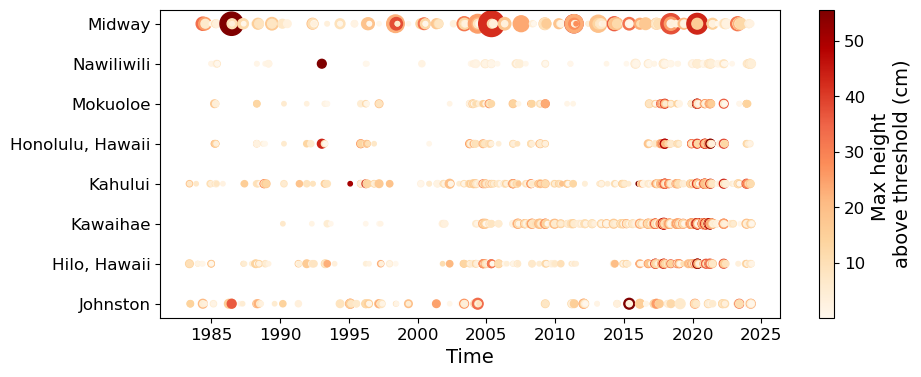

In [111]:
# scatterplot flood duration vs year
from matplotlib.colors import LinearSegmentedColormap

# make figure size small
plt.figure(figsize=(10,4))

# Create a custom color ramp and exclude the lightest shade
full_palette = sns.color_palette("Blues", n_colors=256)
# adjusted_heatmap_palette = full_palette[50:]  # Skip the lightest 50 shades

# Convert the adjusted palette to a colormap
# custom_palette = LinearSegmentedColormap.from_list("custom_blues", adjusted_heatmap_palette)
custom_palette = sns.color_palette("OrRd", as_cmap=True)


# selected_data['duration'] = selected_data['duration'].astype(float)
# flood_durations_ds['month'] = flood_durations_ds['month'].astype(float)

record_ids = flood_data_ds['record_id'].values
station_names = hourly_data['station_name'].sel(record_id=record_ids).values

for i, record_id in enumerate(record_ids):
    # Select data for the current record_id and drop NaNs
    selected_data = flood_data_ds.sel(record_id=record_id).dropna(dim='time')
    
    # Ensure 'duration' is numeric
    selected_data['duration'] = selected_data['duration'].astype(float)
    
    # Plot each station's data on a different y-coordinate
    scatter = plt.scatter(selected_data['time'], [i + 1] * len(selected_data['time']), s=10 * selected_data['duration'], c=selected_data['height'], cmap=custom_palette)

plt.xlabel('Time')
plt.yticks(range(1, len(record_ids) + 1), hourly_data['station_name'].sel(record_id=record_ids).values)  # Set y-ticks to show station labels
plt.colorbar(scatter, label='Max height \nabove threshold (cm)')

# show the colorbar

In [118]:
# turn this duration and height into 'flooding intensity' by multiplying the two
flood_data_ds['intensity'] = flood_data_ds['duration'] * flood_data_ds['height']



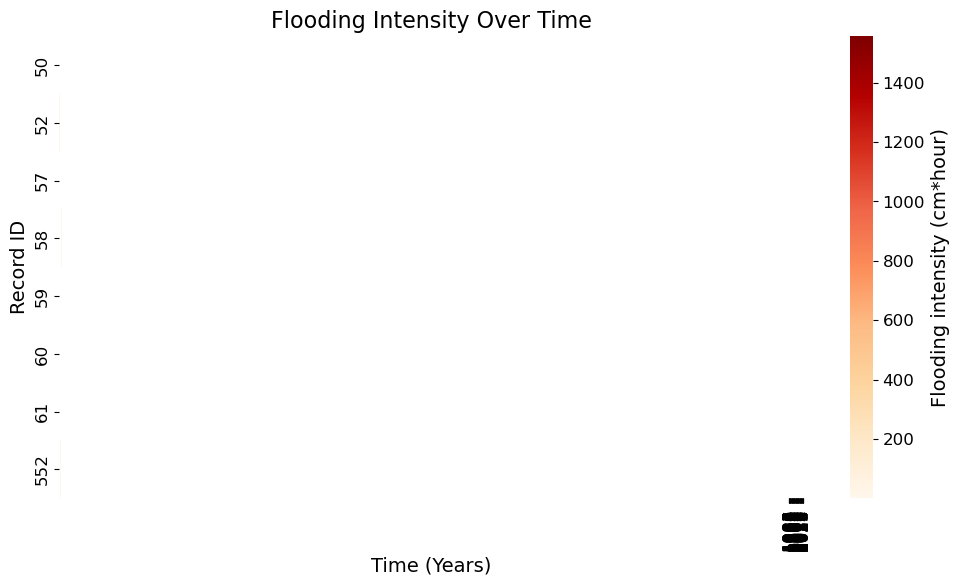

In [114]:
# make pcolormesh plot
plt.figure(figsize=(8,2))
sns.heatmap(flood_data_ds.pivot_table(index='time', columns='record_id', values='duration', aggfunc='mean'), cmap='Blues')

AttributeError: 'Dataset' object has no attribute 'pivot_table'

<Figure size 800x200 with 0 Axes>

In [ ]:
flood_durations_ds['month'] = flood_durations_ds['month'].astype(float)

# Now plot
flood_durations_ds.sel(record_id=57).plot.scatter(x='time', y='month', size='duration', color=adjusted_heatmap_palette[0], s=10)

In [ ]:
flood_durations_ds['month'] = flood_durations_ds['month'].astype(float)

# Now plot
flood_durations_ds.sel(record_id=57).plot.scatter(x='time', y='month', size='duration', color=adjusted_heatmap_palette[0], s=10)

In [94]:
# make dataframe of flood durations
flood_durations_df = pd.DataFrame(flood_durations[57], columns = ['start_time', 'end_time', 'duration'])

# remove rows with duration = 0
flood_durations_df = flood_durations_df[flood_durations_df.duration != 0]

# group by year
flood_durations_df['year'] = flood_durations_df.start_time.dt.year
flood_durations_df['month'] = flood_durations_df.start_time.dt.month

# summary statistics, average duration of flood events by year
year_median = flood_durations_df.groupby('year').duration.median()
year_mean = flood_durations_df.groupby('year').duration.mean()
year_max = flood_durations_df.groupby('year').duration.max()


year_summary = pd.DataFrame({'median': year_median, 'mean': year_mean, 'max': year_max})

# summary statistics, average duration of flood events by month
month_median = flood_durations_df.groupby('month').duration.median()
month_mean = flood_durations_df.groupby('month').duration.mean()
month_max = flood_durations_df.groupby('month').duration.max()

month_summary = pd.DataFrame({'median': month_median, 'mean': month_mean, 'max': month_max})

/Users/juliafiedler/anaconda3/envs/SLI39/lib/python3.9/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


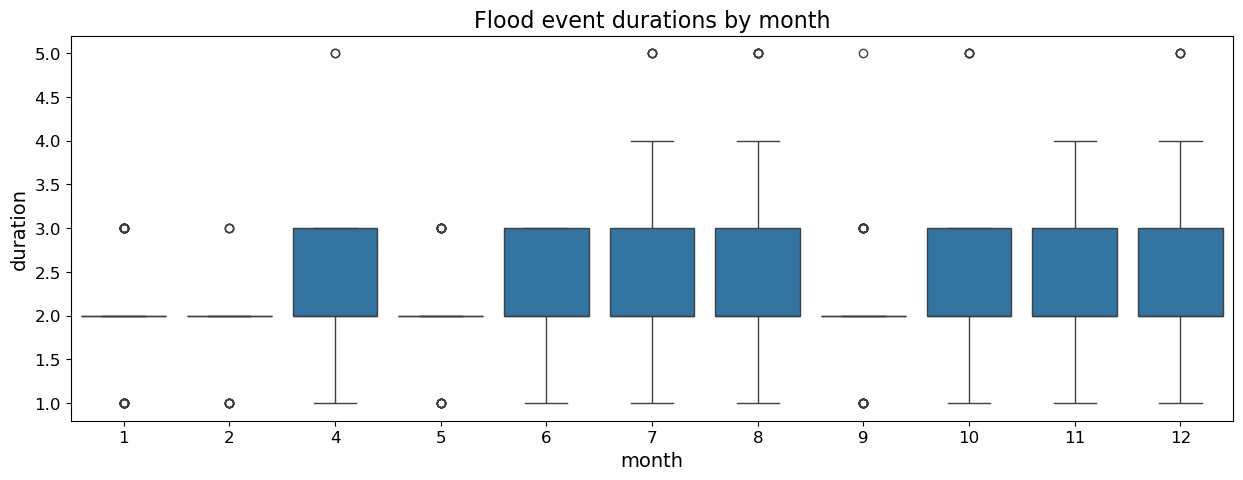

In [95]:
# plt.scatter(year_summary.index, year_summary['mean'], label = 'mean')
# plt.scatter(year_summary.index, year_summary['median'], label = 'median')
# plt.plot(year_summary.index, year_summary['max'], label = 'max')

# make whisker plot of flood event durations by year
plt.figure(figsize = (15, 5))
sns.boxplot(data = flood_durations_df, x = 'month', y = 'duration')
plt.title('Flood event durations by month')
plt.show()

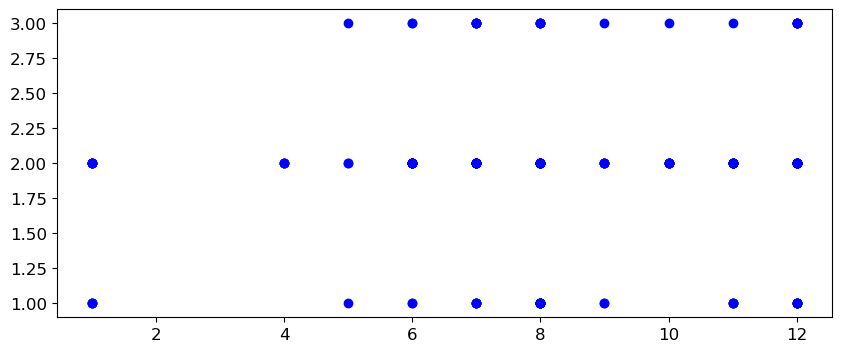

In [69]:
# plot flood events by month and duration
plt.figure()
# plt.plot(month_summary.index, month_summary['mean'], label = 'mean')
plt.scatter(flood_durations_df.month, flood_durations_df.duration, color = 'blue')

In [75]:
# sum flood_hour_df by day
flood_hours_in_day_df = flood_hour_df.resample('D').sum()

In [85]:
flood_hours_in_day_df
flood_hours_in_day_df_57 = flood_hours_in_day_df[57]

flood_hours_in_day_df_57

1983-01-01    0
1983-01-02    0
1983-01-03    0
1983-01-04    0
1983-01-05    0
             ..
2023-12-27    0
2023-12-28    0
2023-12-29    0
2023-12-30    0
2023-12-31    0
Freq: D, Name: 57, Length: 14975, dtype: int64

<BarContainer object of 14975 artists>

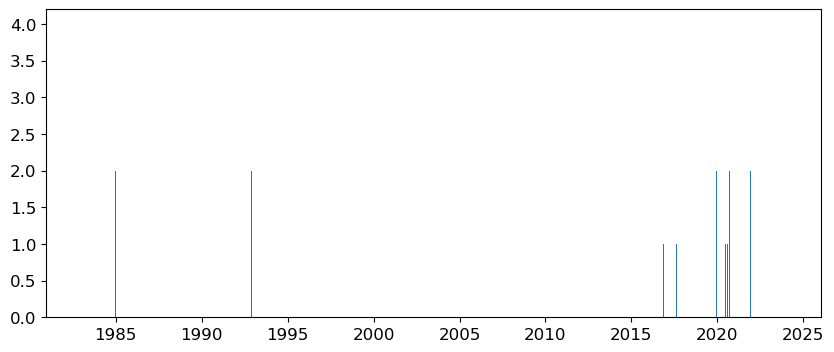

There will be more. This is a placeholder.